# Visualizing features with captum.optim

This notebook demonstrates the use of the `captum.optim` submodule for visualizing features for a MobileNetV2 model imported from `torchvision`. The `optim` submodule shows the increasing complexity of the features learned as we go deeper into the model. We also briefly touch on the `ImageTensor` class for easily loading and visualizing tensors that are also images.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from torchvision.models import alexnet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## ImageTensor

The `ImageTensor` class is a wrapper around `torch.Tensor` that allows for easy loading and viewing of images.

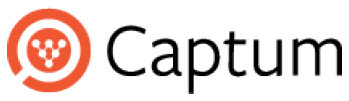

In [ ]:
# Use ImageTensor.open() with a URL or filepath to load an image
t = optimviz.ImageTensor.open(
    "https://raw.githubusercontent.com/pytorch/captum/master/website/static/img/captum_logo.png"
)
# Use show() to quickly view the image.
t.show()

## InputOptimization

`InputOptimization` is the core function for visualizing features with `captum.optim`.

It takes five arguments:
- The model whose feature(s) we are visualizing
- A torch.nn.Module object that generates inputs to the model (e.g. NaturalImage)
- A transformation or series of transformations preprocessing the input before passing to the model
- A list of target layers from the model
- A loss function based on the target layers

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


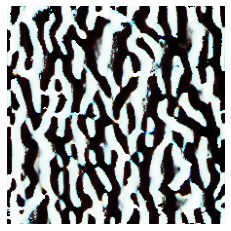

In [ ]:
# Load the model
model = alexnet(pretrained=True).to(device)

# Initialize an input - NaturalImage uses FFT parameterization and color decorrelation
image = optimviz.images.NaturalImage((224, 224)).to(device) # This creates a Module that returns an ImageTensor

# Initialize a series of transformations
transforms = torch.nn.Sequential(
    # Normalization for torchvision models
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Random translation, scaling, and rotation to help with visualization quality.
    # Padding is used to avoid transform artifacts and then it's cropped away.
    torch.nn.ReflectionPad2d(16),
    optimviz.transform.RandomSpatialJitter(16),
    optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5,5)),
    optimviz.transform.RandomSpatialJitter(8),
    optimviz.transform.CenterCrop(16),
)

# Choose a target layer to optimize
target = model.features[1]

# Create a loss function based on the target layer
loss_fn = optimviz.loss.ChannelActivation(target, 5)

# Initialize InputOptimization and run optimize
obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
history = obj.optimize(optimviz.objectives.n_steps(128))

image().show()

For convenience, we can create a helper function for visualizing different layers in our model.

In [ ]:
def visualize(model, target, channel=-1, lr=0.025):
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        torch.nn.ReflectionPad2d(16),
        optimviz.transform.RandomSpatialJitter(16),
        optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.CenterCrop(16),
    )
    if channel > -1:
        loss_fn = optimviz.loss.ChannelActivation(target, channel)
    else:
        loss_fn = optimviz.loss.DeepDream(target)
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn, lr=lr)
    history = obj.optimize(optimviz.objectives.n_steps(128))
    image().show()

With visualization, we can see that deeper features detect for increasingly complex elements.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


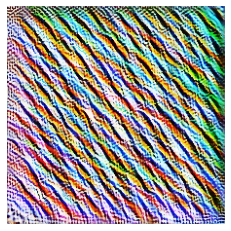

In [ ]:
visualize(model, model.features[4], 15)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


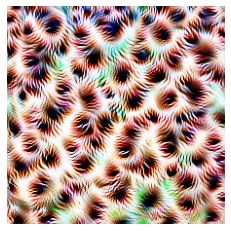

In [ ]:
visualize(model, model.features[9], 8)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


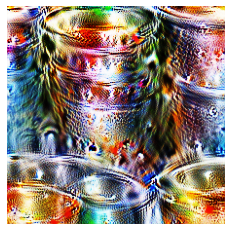

In [ ]:
visualize(model, model.features[11], 14)

We can also visualize different classes in the final layer and see how they are similar to their corresponding ImageNet labels.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


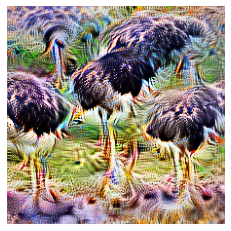

In [ ]:
visualize(model, model.classifier[6], 9) # Ostrich

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


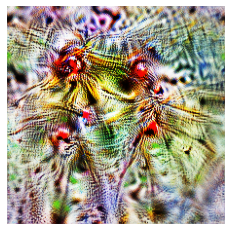

In [ ]:
visualize(model, model.classifier[6], 319) # Dragonfly

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


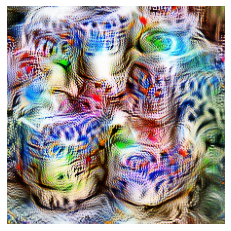

In [ ]:
visualize(model, model.classifier[6], 999) # Toilet paper

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


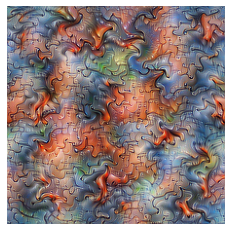

In [ ]:
from torchvision.models import vgg16 # Torchvision's VGG-16 model
model = vgg16(pretrained=True).to(device)
visualize(model, model.features[26], 50) # Optimize without RedirectedReLU

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


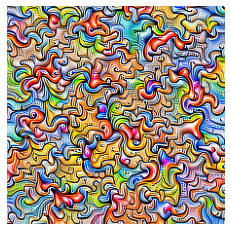

In [ ]:
model = vgg16(pretrained=True).to(device)

# Replace ReLU layers with RedirectedReLU to enhance quality
optimviz._utils.models.replace_layers(model, old_layer=torch.nn.ReLU)

visualize(model, model.features[26], 50) # Optimize without RedirectedReLU